In [1]:
# przetwarzanie danych
import numpy as np
import pandas as pd

# przekształcanie – normalizacja danych
from sklearn.preprocessing import MinMaxScaler

# wizualizacja
import matplotlib.pyplot as plt

# sieci neuronowe
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU

# ewaluacja modelu
from sklearn.metrics import mean_squared_error

In [2]:
dataset = pd.read_csv('airline-passengers.csv')
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.set_index(['Month'], inplace=True)
dataset

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


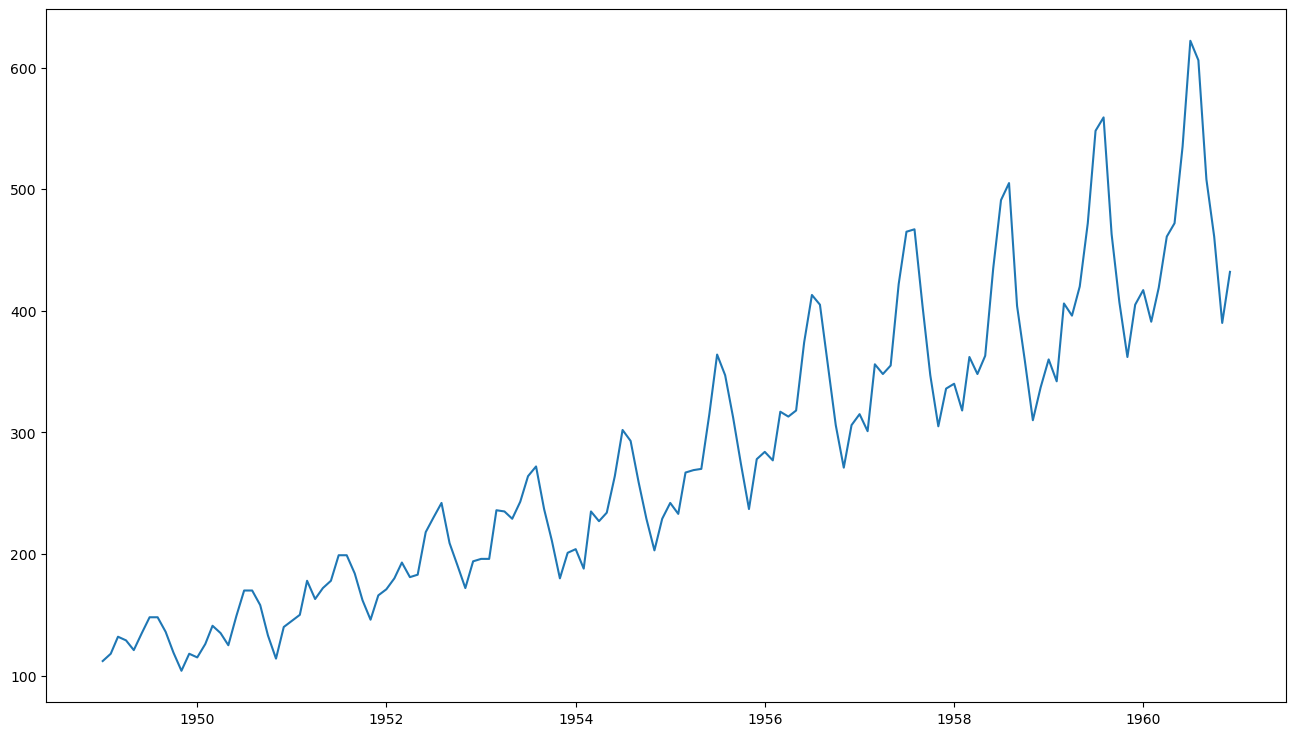

In [3]:
plt.figure(figsize=(16,9))
plt.plot(dataset['Passengers'])
plt.show()

In [4]:
train_size = int(len(dataset) * 0.70)
scaler = MinMaxScaler(feature_range=(0, 1))
look_back = 3
def create_dataset(df, train_size, lback=look_back, scaler_function=scaler):
    test_size = len(df) - train_size
    train, test = df[0:train_size,:].copy(), df[train_size:len(df),:].copy()
    train = scaler_function.fit_transform(train)
    test = scaler_function.transform(test)
    X_train, X_test, y_train, y_test = [], [], [], []

    # Tworzenie zbioru treninowego
    for i in range(len(train)-lback-1):
        a = train[i:(i+lback), 0]
        X_train.append(a)
        y_train.append(train[i + lback, 0])

    # Tworzenie zbioru testowego
    for i in range(len(test)-lback-1):
        a = test[i:(i+lback), 0]
        X_test.append(a)
        y_test.append(test[i + lback, 0])

    X_train, X_test = np.array(X_train), np.array(X_test)
    X_train, X_test = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])), np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    y_train, y_test = np.array(y_train), np.array(y_test)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = create_dataset(df=np.array(dataset), train_size=train_size, lback=look_back)

In [5]:
X_train[:3], y_train[:3]

(array([[[0.02588997, 0.04530744, 0.09061489]],
 
        [[0.04530744, 0.09061489, 0.08090615]],
 
        [[0.09061489, 0.08090615, 0.05501618]]]),
 array([0.08090615, 0.05501618, 0.10032362]))

In [6]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(5, input_shape=(1, look_back)))
model_rnn.add(Dense(1))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
model_rnn.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1)

Epoch 1/200
96/96 [==============================] - 1s 1ms/step - loss: 0.0193
Epoch 2/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 3/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 4/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 5/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0092
Epoch 6/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 7/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0089
Epoch 8/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 9/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0086
Epoch 10/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0085
Epoch 11/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0082
Epoch 12/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0079
Epoch 13/200
96/96 [=================

2/2 [==============================] - 0s 1ms/step


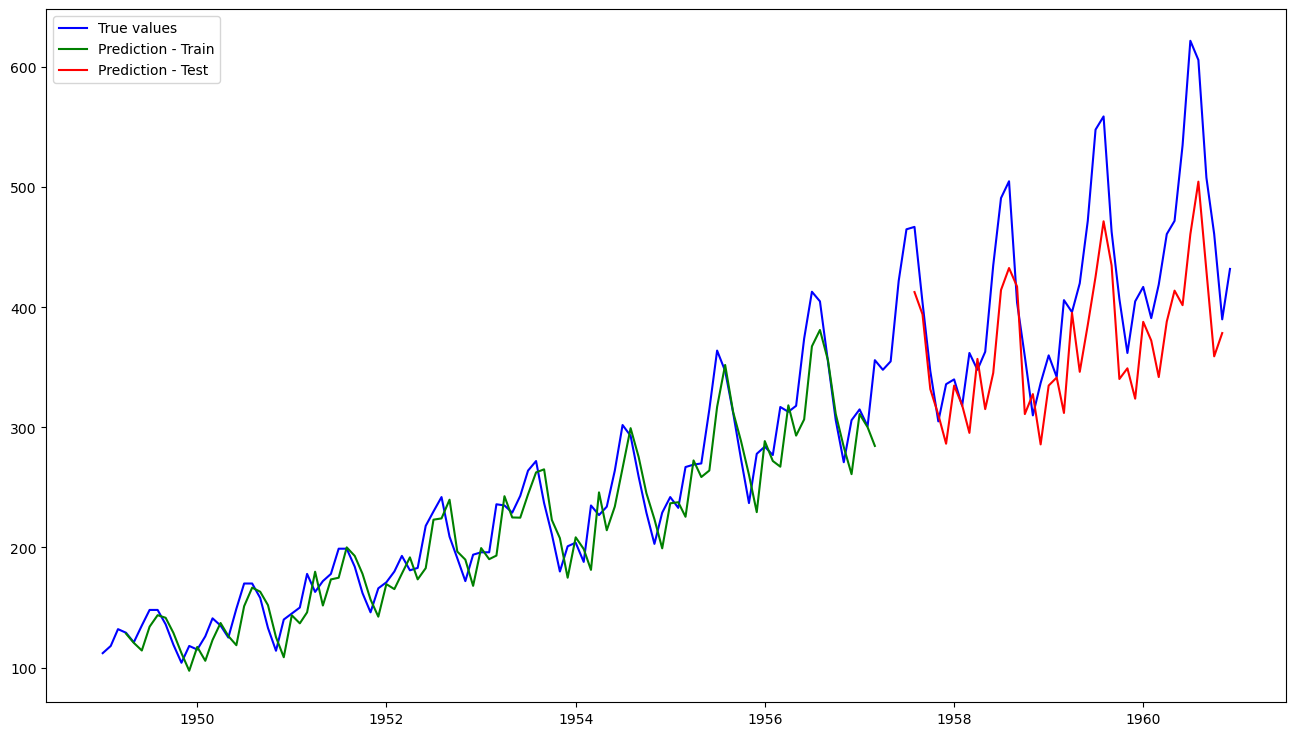


RMSE TEST: 67.15890306525895


In [7]:
def backtests(model, lback=look_back):

    # predykcja - train
    prediction_train = scaler.inverse_transform(model.predict(X_train))
    prediction_train = pd.Series(prediction_train.flatten(),
                                index=dataset.index[lback:len(prediction_train)+lback])

    # predykcja - test
    prediction_test = scaler.inverse_transform(model.predict(X_test))
    prediction_test = pd.Series(prediction_test.flatten(),
                                index=dataset.index[len(prediction_train)+(2*lback)+1:len(dataset)-1])

    # wizualizacja prognozy
    plt.figure(figsize=(16,9))
    plt.plot(dataset['Passengers'], color='blue', label='True values')
    plt.plot(prediction_train, color='green', label='Prediction - Train')
    plt.plot(prediction_test, color='red', label='Prediction - Test')
    plt.legend(loc='upper left')
    plt.show()

    # obliczenie RMSE
    rmse = mean_squared_error(dataset.loc[prediction_test.index, :], prediction_test) ** 0.5
    print(f'\nRMSE TEST: {rmse}')

backtests(model_rnn)

Epoch 1/200
96/96 [==============================] - 13s 8ms/step - loss: 0.0382
Epoch 2/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 3/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 4/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 5/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 6/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 7/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 8/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 9/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 10/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 11/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 12/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 13/200
96/96 [================

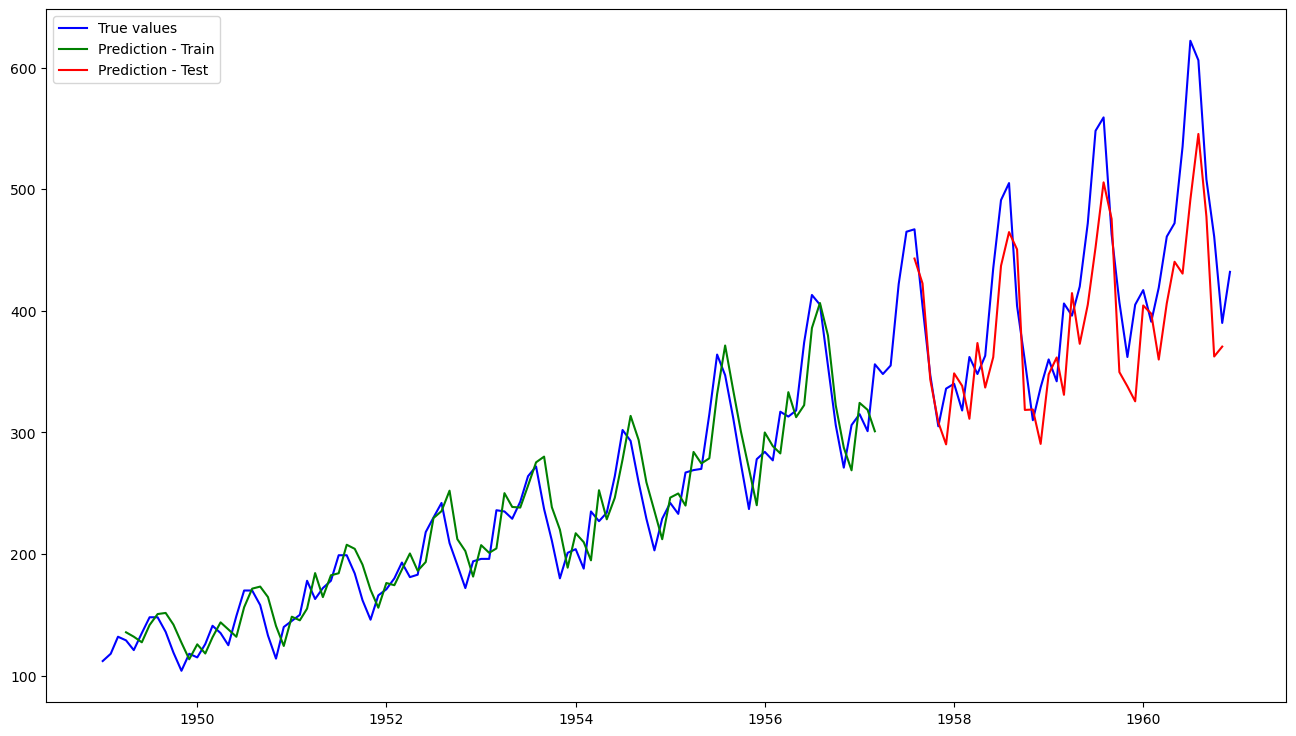


RMSE TEST: 52.30398069859101


In [8]:
model_lstm = Sequential()
model_lstm.add(LSTM(5, input_shape=(1, look_back)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1)
backtests(model_lstm)

Epoch 1/200
96/96 [==============================] - 2s 10ms/step - loss: 0.0643
Epoch 2/200
96/96 [==============================] - 1s 9ms/step - loss: 0.0261
Epoch 3/200
96/96 [==============================] - 1s 8ms/step - loss: 0.0205
Epoch 4/200
96/96 [==============================] - 1s 9ms/step - loss: 0.0173
Epoch 5/200
96/96 [==============================] - 1s 8ms/step - loss: 0.0144
Epoch 6/200
96/96 [==============================] - 1s 8ms/step - loss: 0.0130
Epoch 7/200
96/96 [==============================] - 1s 8ms/step - loss: 0.0119
Epoch 8/200
96/96 [==============================] - 1s 9ms/step - loss: 0.0114
Epoch 9/200
96/96 [==============================] - 1s 9ms/step - loss: 0.0107
Epoch 10/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 11/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 12/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 13/200
96/96 [================

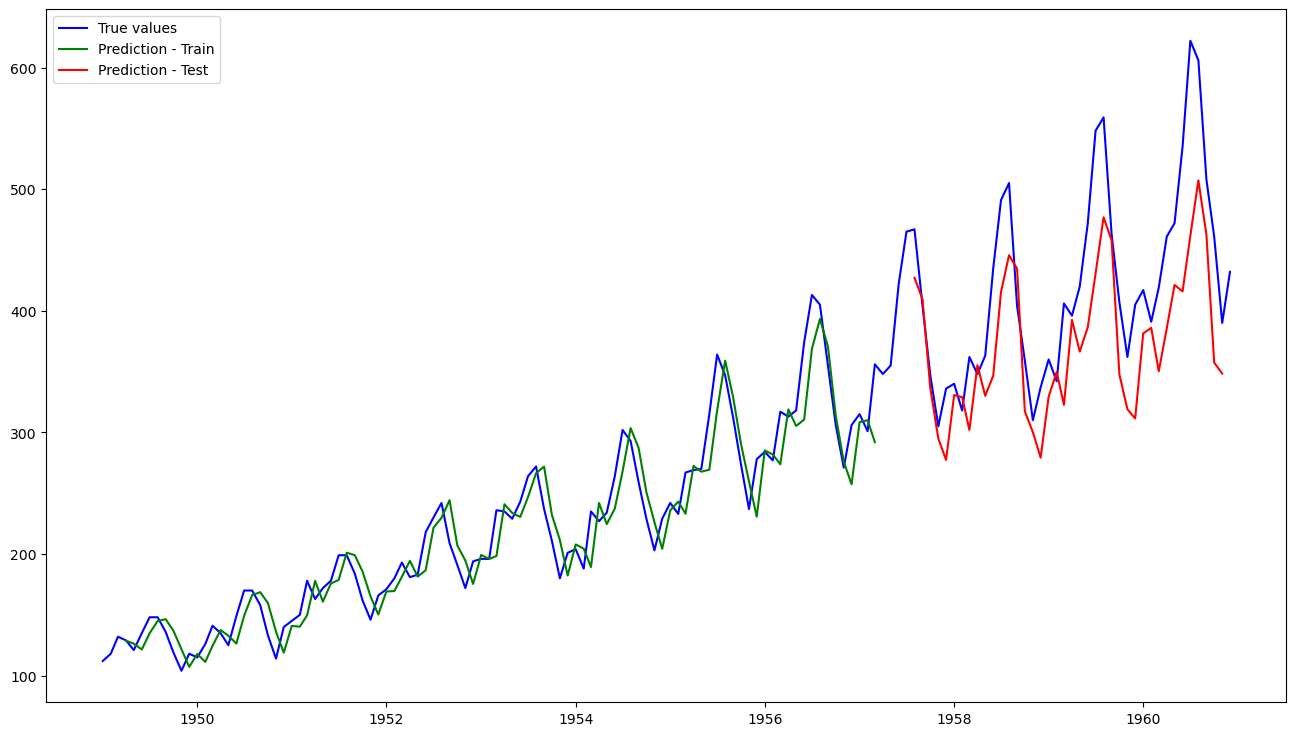


RMSE TEST: 64.14859938944976


In [9]:
model_gru = Sequential()
model_gru.add(GRU(5, input_shape=(1, look_back)))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')
model_gru.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1)
backtests(model_gru)